# Data & Imports

In [1]:
import autokeras as ak
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# constants
path = 'C:/Users/Asus/Documents/2023_2/Memoria/src'

# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines_trim.csv')
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines_trim.csv')
# Observed spectra
Obs_df = pd.read_csv(path+'/Data/observed_spectral_lines_trim_v2.csv')

Using TensorFlow backend


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]
X_obs = Obs_df.drop(target+['HD','date','time'],axis=1)
Y_obs = Obs_df[target]

X = np.random.normal(loc=0, scale=0.01, size=X.shape) + X
y_scaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25, random_state=42)

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)
y_obs = y_scaler.transform(Y_obs.values)

formatted_x_train = np.expand_dims(x_train, axis=2) #This step it's very important an CNN will only accept this data shape
formatted_x_val = np.expand_dims(x_val, axis=2)
formatted_x_test = np.expand_dims(x_test, axis=2)
formatted_x_obs = np.expand_dims(X_obs, axis=2)


c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [10]:
# Density plot function

# https://kdepy.readthedocs.io/en/latest/examples.html#minimal-working-example-with-options
from KDEpy import FFTKDE
from sklearn.neighbors import KernelDensity
import numpy as np

measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[u]', '[km/s]']

def SKL_density_plot(data, ax,low_bound=None,up_bound=None,title='', color='black',alpha=1,label='',kernel='gaussian', bw='silverman',linewidth=1):
  
	if low_bound != None and up_bound != None:
		bw = FFTKDE(bw=bw, kernel='gaussian').fit(data).bw
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		data = np.concatenate((data, 2 * low_bound - data, 2 * up_bound - data))
		kde = KernelDensity(bandwidth=kde.bandwidth_, kernel=kernel).fit(data.reshape(-1,1))
		x = np.linspace(low_bound,up_bound,1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		plot_y = y[np.where((x>=low_bound) & (x<=up_bound))] # Set the KDE to zero outside of the domain
		plot_x = x[np.where((x>=low_bound) & (x<=up_bound))]  # Set the KDE to zero outside of the domain
		plot_y = plot_y * 3  # Double the y-values to get integral of ~1
		ax.plot(plot_x, plot_y, label=label,color=color,alpha=alpha,linewidth=linewidth)
		return x, y, kde
	else:
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		x=np.linspace(data.min(),data.max(),1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		ax.plot(x, y, label=label,color=color,alpha=alpha)
		return x, y, kde

# AutoModel

In [88]:
from keras_tuner.engine import hyperparameters as hp

# convBlock
conv_kernel_size = hp.Choice("kernel_size", [3,5,7,9],)
conv_num_layers = hp.Choice("conv_layers", [1,2,3,4,5],)
conv_num_blocks = hp.Choice("conv_blocks", [1,2,3],)
conv_filters = hp.Choice("filters", [32,64,128,256,512],)

# # DenseBlock
dense_num_layers = hp.Choice("dense_layers", [1,2,3])
dense_units = hp.Choice("dense_units", [32,64,128,256,512])

# RegressionHead
# head_dropout = hp.Float(
#                 'dropout_head',
#                 min_value=0.0,
#                 max_value=0.5,
#                 default=0.25,
#                 step=0.05,
#             )

input = ak.Input()
conv = ak.ConvBlock(
  	kernel_size=conv_kernel_size,
  	num_blocks=conv_num_blocks,
  	num_layers=conv_num_layers,
  	filters=conv_filters,
  	max_pooling=True,
		separable=False,
  	#dropout=conv_dropout,
)(input)
dense = ak.DenseBlock(
  	num_layers=dense_num_layers, 
  	num_units=dense_units, 
  	use_batchnorm=False, 
  	#dropout=dense_dropout
)(conv)
regression_output = ak.RegressionHead(
  	output_dim=3, 
   	loss="mse", 
    metrics=["mae"], 
    #dropout=head_dropout,
)(dense)


def generateAutoModel():
  return ak.AutoModel(
	inputs=input,
	outputs=regression_output,
	max_trials=100,
	loss='mse',
	metrics = 'mae',
	tuner='bayesian',
	overwrite=False,
	seed=19,
	max_model_size=None,)

model = generateAutoModel()


Reloading Tuner from .\auto_model\tuner0.json


In [89]:
model.fit(formatted_x_train, y_train,validation_data=(formatted_x_val, y_val), epochs=20)


Epoch 1/20
459/459 [==============================] - 6s 12ms/step - loss: 0.1070 - mae: 0.2658 - val_loss: 0.0510 - val_mae: 0.1771
Epoch 2/20
459/459 [==============================] - 5s 11ms/step - loss: 0.0562 - mae: 0.1870 - val_loss: 0.0333 - val_mae: 0.1366
Epoch 3/20
459/459 [==============================] - 5s 11ms/step - loss: 0.0432 - mae: 0.1626 - val_loss: 0.0302 - val_mae: 0.1320
Epoch 4/20
459/459 [==============================] - 5s 11ms/step - loss: 0.0386 - mae: 0.1524 - val_loss: 0.0267 - val_mae: 0.1237
Epoch 5/20
459/459 [==============================] - 5s 11ms/step - loss: 0.0352 - mae: 0.1444 - val_loss: 0.0203 - val_mae: 0.1059
Epoch 6/20
459/459 [==============================] - 5s 11ms/step - loss: 0.0336 - mae: 0.1408 - val_loss: 0.0211 - val_mae: 0.1088
Epoch 7/20
459/459 [==============================] - 5s 11ms/step - loss: 0.0330 - mae: 0.1398 - val_loss: 0.0181 - val_mae: 0.0974
Epoch 8/20
459/459 [==============================] - 5s 11ms/step - 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


In [6]:
exp = model.export_model()
exp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 139, 1)]          0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 139, 1)           0         
 t32)                                                            
                                                                 
 conv1d (Conv1D)             (None, 131, 128)          1280      
                                                                 
 conv1d_1 (Conv1D)           (None, 123, 512)          590336    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 512)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7680)              0     

In [90]:
# Evaluate the best model with testing data.
evaluation = model.evaluate(formatted_x_test, y_test)

print('loss: %.3f  MAE:%.3f'% (evaluation[0],evaluation[1]))

153/153 [==============================] - 1s 5ms/step - loss: 0.0169 - mae: 0.0969
loss: 0.017  MAE:0.097


In [91]:
predictions = y_scaler.inverse_transform(model.predict(formatted_x_test))

153/153 [==============================] - 0s 3ms/step


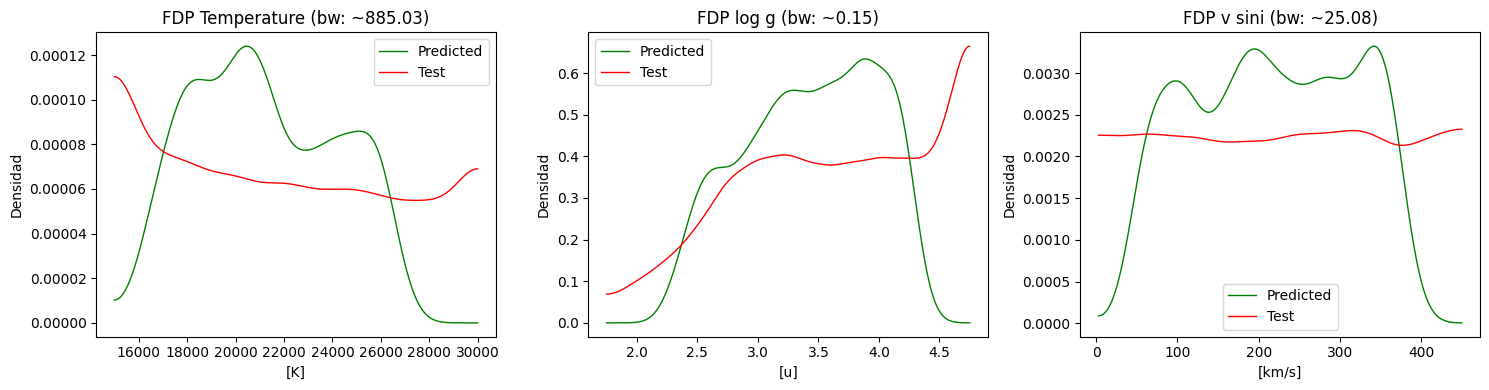

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, featureName in enumerate(target):
	x, y, kde = SKL_density_plot(predictions[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',label='Predicted')
	x, y, kde = SKL_density_plot(y_scaler.inverse_transform(y_test)[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color='red',label='Test')
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[u]', '[km/s]']
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Densidad')
	axes[i].set_title('FDP '+measure[i]+' (bw: ~%.2f'%(kde.bandwidth_)+')')
	axes[i].legend()

plt.legend()
plt.tight_layout();
plt.show()

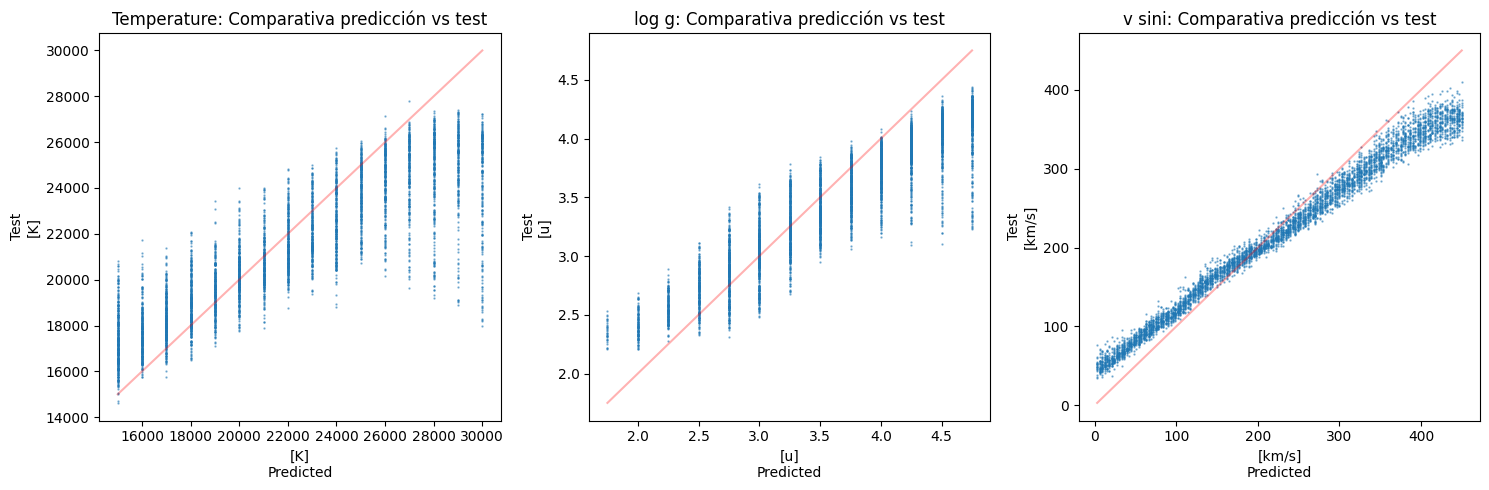

In [93]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=predictions[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs test')
 
plt.tight_layout();
plt.show()

c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


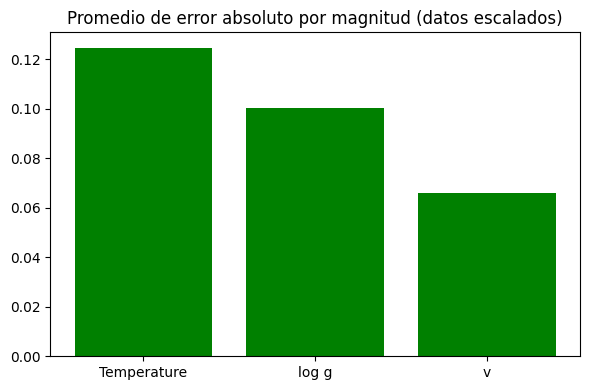

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
x_data = ['Temperature','log g','v']

diff = np.mean(np.abs(y_scaler.transform(predictions)-y_test),axis=0)
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


### Datos de test vs predicción (modelo único)

In [128]:
predictions = y_scaler.inverse_transform(model.predict(formatted_x_train))

inverse_y_train = y_scaler.inverse_transform(y_train)
rel_error = np.abs(predictions-inverse_y_train)*(1/inverse_y_train)*100
abs_error = np.abs(predictions-inverse_y_train)

results = pd.DataFrame({
  'Temp':np.round(inverse_y_train[:,0],0),'Temp_pred':np.round(predictions[:,0],0),'Temp_Abs_Error':np.round(abs_error[:,0]),'Temp_Rel_Error':[str(round(i,1))+'%' for i in rel_error[:,0]],
  'log_g':inverse_y_train[:,1],'log_g_pred':np.round(predictions[:,1],2),'log_g_Abs_Error':np.round(abs_error[:,1],2),'log_g_Rel_Error':[str(round(i,1))+'%' for i in rel_error[:,1]],
  'v':inverse_y_train[:,2],'v_pred':np.round(predictions[:,2]),'v_Abs_Error':np.round(abs_error[:,2]),'v_Rel_Error':[str(round(i,1))+'%' for i in rel_error[:,2]]
                    })
results.head(10)

459/459 [==============================] - 1s 3ms/step


,Temp,Temp_pred,Temp_Abs_Error,Temp_Rel_Error,log_g,log_g_pred,log_g_Abs_Error,log_g_Rel_Error,v,v_pred,v_Abs_Error,v_Rel_Error
0,27000.0,25464.0,1536.0,5.7%,3.75,3.52,0.23,6.3%,153.0,166.0,13.0,8.6%
1,24000.0,21432.0,2568.0,10.7%,4.25,3.94,0.31,7.4%,408.0,347.0,61.0,14.9%
2,17000.0,18462.0,1462.0,8.6%,4.00,3.81,0.19,4.9%,378.0,319.0,59.0,15.5%
3,21000.0,22704.0,1704.0,8.1%,2.50,2.81,0.31,12.5%,345.0,336.0,9.0,2.7%
4,15000.0,15005.0,5.0,0.0%,4.00,3.42,0.58,14.4%,108.0,130.0,22.0,20.6%
5,27000.0,23448.0,3552.0,13.2%,3.25,3.09,0.16,4.8%,213.0,206.0,7.0,3.1%
6,27000.0,26285.0,715.0,2.6%,4.00,3.86,0.14,3.6%,156.0,175.0,19.0,12.2%
7,15000.0,20422.0,5422.0,36.1%,2.00,2.47,0.47,23.4%,447.0,382.0,65.0,14.6%
8,21000.0,22580.0,1580.0,7.5%,3.00,3.22,0.22,7.3%,51.0,88.0,37.0,72.0%
9,18000.0,19729.0,1729.0,9.6%,3.00,3.32,0.32,10.8%,387.0,336.0,51.0,13.1%


### Datos observados vs predicción de modelo único

In [129]:
# tabla de resultados modelo unico
predictions = y_scaler.inverse_transform(model.predict(formatted_x_obs))

inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(predictions-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(predictions-inverse_y_obs)

results = pd.DataFrame({
  'Temp':np.round(inverse_y_obs[:,0],0),'Temp_pred':np.round(predictions[:,0],0),'Temp_Rel_Error':[str(round(i,1))+'%' for i in rel_error[:,0]],
  'log_g':inverse_y_obs[:,1],'log_g_pred':np.round(predictions[:,1],2),'log_g_Rel_Error':[str(round(i,1))+'%' for i in rel_error[:,1]],
  'v':inverse_y_obs[:,2],'v_pred':np.round(predictions[:,2]),'v_Rel_Error':[str(round(i,1))+'%' for i in rel_error[:,2]]
                    }).join(Obs_df.HD).set_index('HD')
results.head(10)

3/3 [==============================] - 0s 21ms/step


,Temp,Temp_pred,Temp_Rel_Error,log_g,log_g_pred,log_g_Rel_Error,v,v_pred,v_Rel_Error
HD,,,,,,,,,
33328,19526.0,16672.0,14.6%,3.3,3.76,13.9%,287.0,282.0,1.7%
33328,19526.0,18039.0,7.6%,3.3,3.62,9.8%,287.0,290.0,1.0%
33328,19526.0,19639.0,0.6%,3.3,3.59,8.7%,287.0,279.0,2.9%
33328,19526.0,12611.0,35.4%,3.3,4.00,21.2%,287.0,280.0,2.5%
33328,19526.0,17364.0,11.1%,3.3,3.88,17.5%,287.0,292.0,1.6%
35165,17000.0,16049.0,5.6%,4.0,4.08,1.9%,240.0,262.0,9.1%
35165,17000.0,17091.0,0.5%,4.0,4.19,4.8%,240.0,248.0,3.2%
35165,17000.0,17000.0,0.0%,4.0,3.93,1.9%,240.0,250.0,4.2%
35165,17000.0,21623.0,27.2%,4.0,3.50,12.5%,240.0,297.0,23.7%


In [44]:
# / TODO ponerle titulo a las cosas 
# / TODO mostrar tabla con datos sintéticos
# / TODO mostrar fdp datos sinteticos
# / TODO mostrar resultados prediccion de datos observados
# TODO distribucion predictiva de datos observados
# / TODO agregar ruido a todas las particiones de x 
# / TODO mostrar el error
# / TODO graficar comparativa de espectro observado con sintetico
# / TODO entender como se llego a la red nuronal
# / TODO volver a generar instancia de entrenamiento de autokeras

# Ensemble

In [45]:
from scipy.sparse import coo_matrix
from sklearn.utils import resample

NUM_MODELS = 30
models = []
history = []

x_train_sparse = coo_matrix(x_train)

for i in range(NUM_MODELS):
	am = generateAutoModel()
	x_train_resampled, x_train_sparse, y_train_resampled = resample(x_train, x_train_sparse, y_train, random_state=i)
	x_train_resampled = np.expand_dims(x_train_resampled, axis=2)
	history.append(am.fit(x=x_train_resampled, y=y_train_resampled, epochs=30))
	models.append(am.export_model())

Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 10ms/step - loss: 0.1234 - mae: 0.2846
Epoch 2/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0551 - mae: 0.1845
Epoch 3/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0403 - mae: 0.1562
Epoch 4/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0354 - mae: 0.1452
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0337 - mae: 0.1421
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0327 - mae: 0.1394
Epoch 7/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0319 - mae: 0.1380
Epoch 8/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0317 - mae: 0.1372
Epoch 9/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0311 - mae: 0.1359
Epoch 10/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0302 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 10ms/step - loss: 0.1101 - mae: 0.2689
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0584 - mae: 0.1898
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0444 - mae: 0.1636
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0370 - mae: 0.1482
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0344 - mae: 0.1422
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0332 - mae: 0.1400
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0331 - mae: 0.1397
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0325 - mae: 0.1386
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0315 - mae: 0.1362
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0310 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.1124 - mae: 0.2710
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0567 - mae: 0.1880
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0430 - mae: 0.1621
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0388 - mae: 0.1535
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0371 - mae: 0.1491
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0353 - mae: 0.1448
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0345 - mae: 0.1428
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0335 - mae: 0.1407
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0313 - mae: 0.1359
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0298 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.1026 - mae: 0.2551
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0549 - mae: 0.1838
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0461 - mae: 0.1686
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0437 - mae: 0.1635
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0419 - mae: 0.1596
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0412 - mae: 0.1578
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0399 - mae: 0.1552
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0388 - mae: 0.1525
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0378 - mae: 0.1506
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0371 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 10ms/step - loss: 0.1112 - mae: 0.2726
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0547 - mae: 0.1838
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0381 - mae: 0.1511
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0348 - mae: 0.1438
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0329 - mae: 0.1396
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0317 - mae: 0.1366
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0307 - mae: 0.1344
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0302 - mae: 0.1333
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0300 - mae: 0.1330
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0293 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 10ms/step - loss: 0.1087 - mae: 0.2690
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0564 - mae: 0.1863
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0422 - mae: 0.1597
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0367 - mae: 0.1479
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0353 - mae: 0.1449
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0343 - mae: 0.1425
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0336 - mae: 0.1415
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0334 - mae: 0.1408
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0327 - mae: 0.1393
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0325 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.1042 - mae: 0.2577
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0524 - mae: 0.1787
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0385 - mae: 0.1519
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0348 - mae: 0.1438
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0333 - mae: 0.1403
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0326 - mae: 0.1390
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0315 - mae: 0.1363
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0311 - mae: 0.1347
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0302 - mae: 0.1333
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0294 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0992 - mae: 0.2514
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0518 - mae: 0.1774
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0393 - mae: 0.1543
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0348 - mae: 0.1440
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0329 - mae: 0.1396
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0321 - mae: 0.1379
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0319 - mae: 0.1372
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0308 - mae: 0.1346
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0298 - mae: 0.1321
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0302 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 10ms/step - loss: 0.1239 - mae: 0.2828
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0601 - mae: 0.1926
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0429 - mae: 0.1611
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0387 - mae: 0.1522
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0358 - mae: 0.1461
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0336 - mae: 0.1412
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0316 - mae: 0.1366
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0309 - mae: 0.1349
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0308 - mae: 0.1349
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0296 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0917 - mae: 0.2400
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0475 - mae: 0.1687
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0386 - mae: 0.1516
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0345 - mae: 0.1431
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0325 - mae: 0.1385
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0308 - mae: 0.1341
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0303 - mae: 0.1334
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0292 - mae: 0.1304
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0287 - mae: 0.1294
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0283 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 10ms/step - loss: 0.1032 - mae: 0.2625
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0556 - mae: 0.1845
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0366 - mae: 0.1479
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0326 - mae: 0.1384
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0307 - mae: 0.1343
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0302 - mae: 0.1332
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0298 - mae: 0.1325
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0298 - mae: 0.1323
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0291 - mae: 0.1307
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0282 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.1044 - mae: 0.2583
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0509 - mae: 0.1757
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0379 - mae: 0.1510
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0355 - mae: 0.1455
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0332 - mae: 0.1404
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0321 - mae: 0.1383
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0314 - mae: 0.1361
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0314 - mae: 0.1363
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0308 - mae: 0.1348
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0298 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0995 - mae: 0.2503
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0535 - mae: 0.1818
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0387 - mae: 0.1519
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0353 - mae: 0.1444
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0331 - mae: 0.1396
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0319 - mae: 0.1369
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0316 - mae: 0.1366
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0313 - mae: 0.1354
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0302 - mae: 0.1329
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0300 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 10ms/step - loss: 0.1035 - mae: 0.2612
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0551 - mae: 0.1827
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0455 - mae: 0.1653
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0398 - mae: 0.1549
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0374 - mae: 0.1493
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0356 - mae: 0.1449
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0336 - mae: 0.1408
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0329 - mae: 0.1392
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0330 - mae: 0.1399
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0320 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 10ms/step - loss: 0.1088 - mae: 0.2666
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0582 - mae: 0.1902
Epoch 3/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0421 - mae: 0.1602
Epoch 4/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0376 - mae: 0.1506
Epoch 5/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0360 - mae: 0.1469
Epoch 6/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0350 - mae: 0.1446
Epoch 7/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0345 - mae: 0.1437
Epoch 8/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0348 - mae: 0.1447
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0336 - mae: 0.1414
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0324 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 10ms/step - loss: 0.1006 - mae: 0.2596
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0531 - mae: 0.1793
Epoch 3/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0402 - mae: 0.1551
Epoch 4/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0362 - mae: 0.1469
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0347 - mae: 0.1437
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0339 - mae: 0.1416
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0329 - mae: 0.1392
Epoch 8/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0317 - mae: 0.1370
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0310 - mae: 0.1352
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0310 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 10ms/step - loss: 0.1135 - mae: 0.2772
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0642 - mae: 0.2016
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0408 - mae: 0.1570
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0354 - mae: 0.1456
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0325 - mae: 0.1393
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0315 - mae: 0.1366
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0309 - mae: 0.1354
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0294 - mae: 0.1313
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0295 - mae: 0.1318
Epoch 10/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0284 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0971 - mae: 0.2508
Epoch 2/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0525 - mae: 0.1787
Epoch 3/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0421 - mae: 0.1589
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0375 - mae: 0.1495
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0358 - mae: 0.1464
Epoch 6/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0348 - mae: 0.1444
Epoch 7/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0331 - mae: 0.1399
Epoch 8/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0319 - mae: 0.1371
Epoch 9/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0309 - mae: 0.1350
Epoch 10/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0303 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0952 - mae: 0.2489
Epoch 2/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0564 - mae: 0.1861
Epoch 3/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0399 - mae: 0.1546
Epoch 4/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0353 - mae: 0.1445
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0336 - mae: 0.1405
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0329 - mae: 0.1394
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0325 - mae: 0.1380
Epoch 8/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0319 - mae: 0.1366
Epoch 9/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0317 - mae: 0.1365
Epoch 10/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0309 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 6s 11ms/step - loss: 0.1058 - mae: 0.2679
Epoch 2/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0580 - mae: 0.1900
Epoch 3/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0469 - mae: 0.1687
Epoch 4/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0395 - mae: 0.1546
Epoch 5/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0371 - mae: 0.1490
Epoch 6/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0357 - mae: 0.1459
Epoch 7/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0349 - mae: 0.1438
Epoch 8/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0342 - mae: 0.1425
Epoch 9/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0335 - mae: 0.1406
Epoch 10/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0333 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 6s 11ms/step - loss: 0.1122 - mae: 0.2760
Epoch 2/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0667 - mae: 0.2086
Epoch 3/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0478 - mae: 0.1714
Epoch 4/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0398 - mae: 0.1555
Epoch 5/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0358 - mae: 0.1464
Epoch 6/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0348 - mae: 0.1439
Epoch 7/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0340 - mae: 0.1416
Epoch 8/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0338 - mae: 0.1416
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0334 - mae: 0.1409
Epoch 10/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0332 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 6s 12ms/step - loss: 0.1144 - mae: 0.2710
Epoch 2/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0539 - mae: 0.1821
Epoch 3/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0460 - mae: 0.1666
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0425 - mae: 0.1601
Epoch 5/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0395 - mae: 0.1534
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0374 - mae: 0.1490
Epoch 7/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0348 - mae: 0.1430
Epoch 8/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0329 - mae: 0.1387
Epoch 9/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0320 - mae: 0.1369
Epoch 10/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0306 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 6s 11ms/step - loss: 0.1101 - mae: 0.2677
Epoch 2/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0555 - mae: 0.1861
Epoch 3/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0389 - mae: 0.1537
Epoch 4/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0348 - mae: 0.1447
Epoch 5/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0330 - mae: 0.1398
Epoch 6/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0320 - mae: 0.1380
Epoch 7/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0305 - mae: 0.1343
Epoch 8/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0298 - mae: 0.1330
Epoch 9/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0294 - mae: 0.1315
Epoch 10/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0291 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 10ms/step - loss: 0.1045 - mae: 0.2612
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0582 - mae: 0.1899
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0456 - mae: 0.1655
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0389 - mae: 0.1521
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0348 - mae: 0.1437
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0334 - mae: 0.1401
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0323 - mae: 0.1377
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0311 - mae: 0.1352
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0306 - mae: 0.1336
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0299 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0972 - mae: 0.2502
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0530 - mae: 0.1798
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0452 - mae: 0.1653
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0410 - mae: 0.1569
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0392 - mae: 0.1528
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0371 - mae: 0.1481
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0368 - mae: 0.1476
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0354 - mae: 0.1441
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0346 - mae: 0.1425
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0337 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 10ms/step - loss: 0.1030 - mae: 0.2600
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0511 - mae: 0.1762
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0369 - mae: 0.1479
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0343 - mae: 0.1418
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0324 - mae: 0.1379
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0321 - mae: 0.1374
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0310 - mae: 0.1351
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0305 - mae: 0.1337
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0301 - mae: 0.1328
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0293 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.1034 - mae: 0.2595
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0521 - mae: 0.1778
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0372 - mae: 0.1486
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0344 - mae: 0.1430
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0336 - mae: 0.1414
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0320 - mae: 0.1379
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0321 - mae: 0.1386
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0304 - mae: 0.1341
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0299 - mae: 0.1333
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0300 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0854 - mae: 0.2353
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0510 - mae: 0.1753
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0401 - mae: 0.1542
Epoch 4/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0334 - mae: 0.1401
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0316 - mae: 0.1361
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0308 - mae: 0.1344
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0301 - mae: 0.1326
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0300 - mae: 0.1326
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0292 - mae: 0.1304
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0290 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0918 - mae: 0.2428
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0493 - mae: 0.1735
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0394 - mae: 0.1537
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0366 - mae: 0.1476
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0351 - mae: 0.1448
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0340 - mae: 0.1427
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0330 - mae: 0.1404
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0327 - mae: 0.1398
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0316 - mae: 0.1370
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0322 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.1044 - mae: 0.2625
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0531 - mae: 0.1806
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0379 - mae: 0.1505
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0347 - mae: 0.1436
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0325 - mae: 0.1388
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0313 - mae: 0.1363
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0306 - mae: 0.1343
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0304 - mae: 0.1338
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0303 - mae: 0.1337
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0298 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


In [46]:
# prediccion de datos observados
predictions = np.array([y_scaler.inverse_transform(model.predict(formatted_x_test)) for model in models]) # dim(predictions) = (num_models, num_rows, num_outputs)

153/153 [==============================] - 1s 3ms/step


In [47]:
# prediccion del ensamble e incerteza
weights = [model.evaluate(formatted_x_test, y_test)[0] for model in models]
weights = [weight/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])**(1/2)


153/153 [==============================] - 1s 4ms/step - loss: 0.0137 - mae: 0.0874


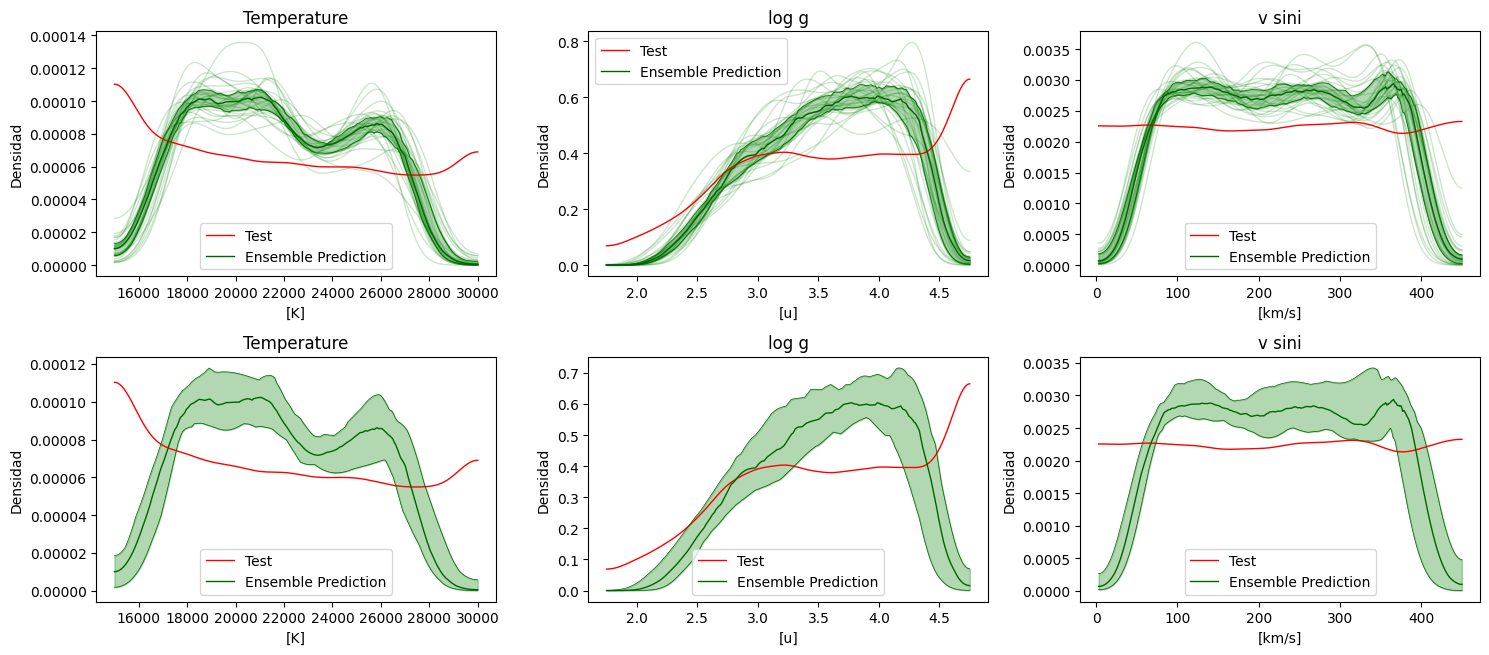

In [48]:
# Ref: https://stackoverflow.com/questions/60130503/plotting-bars-hist-and-pdf-line-via-kdeplot
import scipy.stats as st
from scipy.interpolate import interp1d

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,6.66))

for i, featureName in enumerate(target):
	x_space = np.linspace(Y[featureName].min(), Y[featureName].max(), 2**12)
	heights = []
	for j in range(NUM_MODELS):
		prediction_y = predictions[j,:,i] # your data goes here
		x,y,prediction_kde = SKL_density_plot(prediction_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',alpha=0.2)
		f = interp1d(x, y, kind="linear", assume_sorted=True)
		h = f(x_space)*3
		heights.append(h)
  
	heights = np.array(heights)
 
	rescaled_y = y_scaler.inverse_transform(y_test)[:,i]
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[1,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	f = interp1d(x, y, kind="linear", assume_sorted=True)
	test_h = f(x_space)
 
	# cuantiles 50% de los datos
	q25 = np.quantile(heights,0.25,axis=0)
	q75 = np.quantile(heights,0.75,axis=0)
	axes[0,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[0,i].plot(x_space, q25,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].plot(x_space, q75,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].fill_between(x_space, q25,q75, alpha=0.30, color='green')
	
	# cuantiles 95% de los datos
	q5 = np.quantile(heights,0.05,axis=0)
	q95 = np.quantile(heights,0.95,axis=0)
	axes[1,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[1,i].plot(x_space, q5,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].plot(x_space, q95,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].fill_between(x_space, q5,q95, alpha=0.30, color='green')
	
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[u]', '[km/s]']
	axes[1,i].set_xlabel(measure_unit[i])
	axes[1,i].set_ylabel('Densidad')
	axes[1,i].legend()
	axes[1,i].set_title(measure[i])

	axes[0,i].set_xlabel(measure_unit[i])
	axes[0,i].set_ylabel('Densidad')
	axes[0,i].legend()
	axes[0,i].set_title(measure[i])


plt.tight_layout()
plt.show()

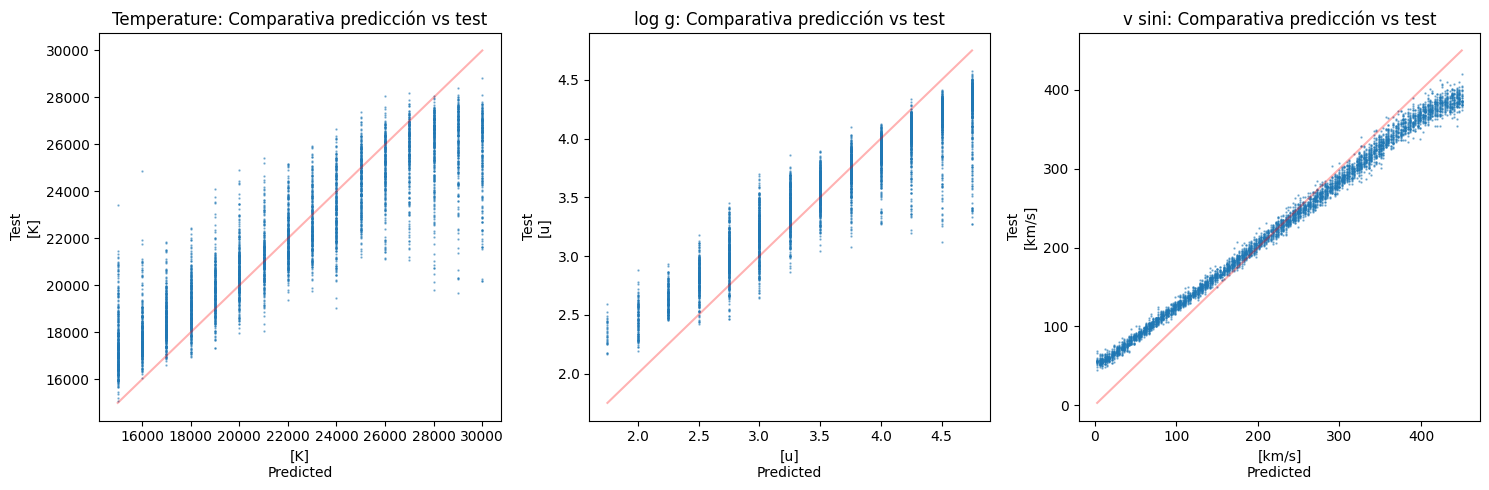

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=ensemble_prediction[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs test')
 
plt.tight_layout();
plt.show()

c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.w

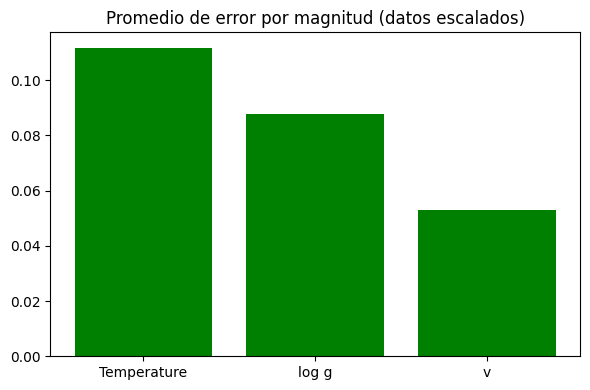

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
x_data = ['Temperature','log g','v']

diff = np.mean(np.array([np.abs(y_scaler.transform(y_hat)-y_test) for y_hat in predictions]),axis=(0,1))
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


### Datos de test vs predicción (ensamble)

In [54]:
# / TODO Error relativo-absoluto agregado en la tabla
# / TODO scatter de valor esperado sobre prediccion
# TODO graficar comparativa entre estrella sitentica y real
# TODO grafica con vecindario de espectro real

In [55]:
# dataframe
inverse_y_test = y_scaler.inverse_transform(y_test)
results = pd.DataFrame({
  'Temp':inverse_y_test[:,0],'Temp_pred':ensemble_prediction[:,0],'Temp_Variance':uncertainty[:,0],
  'log_g':inverse_y_test[:,1],'log_g_pred':ensemble_prediction[:,1],'log_g_Variance':uncertainty[:,1],
  'v':inverse_y_test[:,2],'v_pred':ensemble_prediction[:,2],'v_Variance':uncertainty[:,2]
                    })
results.head(10)

,Temp,Temp_pred,Temp_Variance,log_g,log_g_pred,log_g_Variance,v,v_pred,v_Variance
0,28000.0,24542.390625,1773.484985,2.75,2.808074,0.154106,156.0,166.859680,7.069024
1,27000.0,26481.388672,568.389221,4.25,4.141155,0.091091,24.0,63.372852,9.387226
2,28000.0,27330.917969,455.165314,4.50,4.252112,0.097510,213.0,216.503433,8.241320
3,28000.0,27459.146484,479.666962,4.50,4.265945,0.084107,36.0,72.619682,9.272123
4,16000.0,17484.931641,672.102295,2.50,3.110456,0.168340,327.0,304.971191,12.824323
5,18000.0,18461.064453,457.456177,3.25,3.596891,0.119085,216.0,211.362335,7.003615
6,22000.0,22638.044922,789.962769,3.50,3.537585,0.093053,54.0,89.474258,9.458206
7,21000.0,19834.925781,621.761047,3.25,3.552006,0.136856,321.0,298.217438,8.048053
8,18000.0,18544.646484,464.566437,3.75,3.810732,0.117348,72.0,99.119896,9.195285
9,20000.0,20475.949219,595.530396,4.00,3.838370,0.090123,138.0,153.393250,10.451739


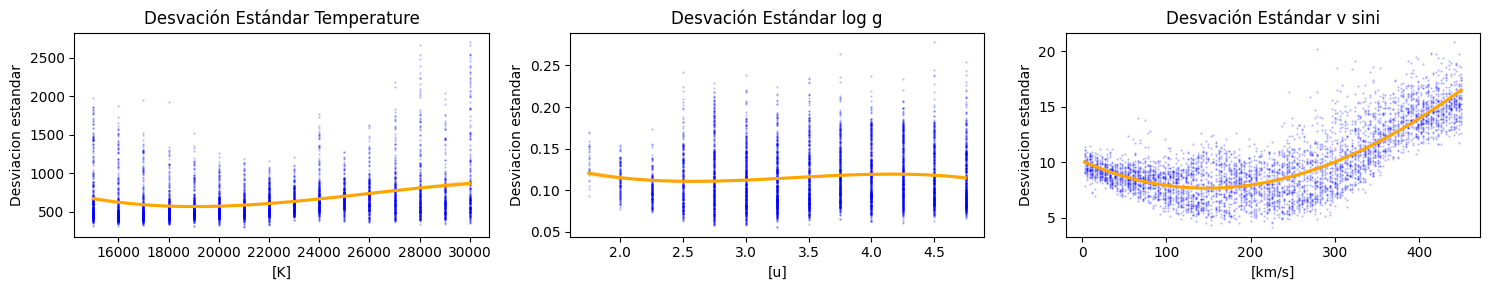

In [56]:
# TODO: algo que permita ver el tamano de las varianzas sobre target feature
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
feat=['Temp', 'log_g',	'v']
vari=['Temp_Variance','log_g_Variance','v_Variance']
measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[u]', '[km/s]']

for i, featureName in enumerate(target):
	x_data = y_scaler.inverse_transform(y_test)[:,i]
	y_data = uncertainty[:,i]
	sns.regplot(x=feat[i], y=vari[i], data=results,ax=axes[i],scatter_kws=dict(alpha=0.2,color='blue',s=0.5),line_kws=dict(color='orange'), order=3);
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel("Desviacion estandar")
	axes[i].set_title('Desvación Estándar '+measure[i])
	#axes[i].legend()
  
plt.tight_layout()
plt.show()

### Datos observados vs predicción (ensamble)

In [57]:
# generar predicciones e incerteza de ensamble
predictions = np.array([y_scaler.inverse_transform(model.predict(formatted_x_obs)) for model in models])
ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])**(1/2)

3/3 [==============================] - 0s 10ms/step


In [85]:
# data processing for formatted table

# error sign: ±

formatted_temperature = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,0],uncertainty[:,0])]
formatted_log_g = [str(round(i,2))+' ± '+str(round(j,2)) for i,j in zip(ensemble_prediction[:,1],uncertainty[:,1])]
formatted_v = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,2],uncertainty[:,2])]

In [133]:
# dataframe comparativo de datos observados
inverse_y_obs = y_scaler.inverse_transform(y_obs)
results = pd.DataFrame({
  'Temperatura':inverse_y_obs[:,0],'Prediccion_Tempratura':formatted_temperature,'ErrorAbs_Temperatura':np.round(np.abs(inverse_y_obs[:,0]-ensemble_prediction[:,0])),
  'log_g':inverse_y_obs[:,1],'Prediccion_log_g':formatted_log_g,'ErrorAbs_log_g':np.round(np.abs(inverse_y_obs[:,1]-ensemble_prediction[:,1]),decimals=2),
  'v':inverse_y_obs[:,2],'Prediccion_v':formatted_v,'ErrorAbs_v':np.round(np.abs(inverse_y_obs[:,2]-ensemble_prediction[:,2])),
                    }).join(Obs_df.HD).set_index('HD')
results.head(60)

,Temperatura,Prediccion_Tempratura,ErrorAbs_Temperatura,log_g,Prediccion_log_g,ErrorAbs_log_g,v,Prediccion_v,ErrorAbs_v
HD,,,,,,,,,
33328,19526.0,16954 ± 780,2572.0,3.30,3.82 ± 0.15,0.52,287.0,266 ± 12,21.0
33328,19526.0,18079 ± 663,1447.0,3.30,3.73 ± 0.15,0.43,287.0,277 ± 10,10.0
33328,19526.0,20007 ± 527,481.0,3.30,3.53 ± 0.11,0.23,287.0,288 ± 9,1.0
33328,19526.0,13686 ± 1647,5840.0,3.30,4.26 ± 0.26,0.96,287.0,281 ± 33,6.0
33328,19526.0,17722 ± 705,1804.0,3.30,4.1 ± 0.18,0.80,287.0,286 ± 16,1.0
35165,17000.0,16558 ± 1162,442.0,4.00,4.5 ± 0.18,0.50,240.0,251 ± 26,11.0
35165,17000.0,17353 ± 918,353.0,4.00,4.53 ± 0.18,0.53,240.0,254 ± 21,14.0
35165,17000.0,16986 ± 1273,14.0,4.00,4.18 ± 0.19,0.18,240.0,239 ± 22,1.0
35165,17000.0,22898 ± 1899,5898.0,4.00,3.58 ± 0.24,0.42,240.0,299 ± 15,59.0


In [59]:
# / TODO revisar drive con datos de estrellas pucheros
# TODO hacer tabla comparativa con valores predichos y comparar con tabla del paper
# / TODO revisar parametros para probar con autokeras
# / TODO corregir graficos, intervalo de confianza(25%) + distribuciones puntuales, intervalo de confianza 95% sin distribuciones puntuales
# / TODO scatter de valor observado/testing vs prediccion 3 graficos
# / TODO corregir en vez de varianza, std dev
# / TODO grafica comparativa de error con valores escalados 